In [1]:
import itertools
import pickle
import random
import time
from collections import defaultdict
from itertools import zip_longest

import matplotlib.pyplot as plt
import torch
import networkx as nx
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import degree, from_networkx, to_networkx
from torch_scatter import scatter_mean

In [2]:
def plot_mutag(
    graph1, graph2=None, original_x1=None, perm1=None, original_x2=None, perm2=None
):
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib
    import matplotlib.patches as mpatches
    from torch_geometric.utils import to_networkx

    colormap = matplotlib.colormaps.get_cmap("Pastel1")

    color_map = {
        0: colormap(0),  # C
        1: colormap(1),  # O
        2: colormap(2),  # Cl
        3: colormap(3),  # H
        4: colormap(4),  # N
        5: colormap(5),  # F
        6: colormap(6),  # Br
        7: colormap(7),  # S
        8: colormap(8),  # P
        9: colormap(9),  # I
        "other": "gray",
    }

    atom_types = {
        0: "C",
        1: "O",
        2: "Cl",
        3: "H",
        4: "N",
        5: "F",
        6: "Br",
        7: "S",
        8: "P",
        9: "I",
    }

    def plot_single_graph(graph, ax, original_x=None, perm=None):
        G = to_networkx(graph, to_undirected=True)

        node_colors = []
        node_labels = {}

        if original_x is not None and perm is not None:
            mapped_x = original_x[perm[: graph.num_nodes]]
            for node in range(graph.num_nodes):
                one_hot = mapped_x[node].tolist()
                try:
                    node_type = one_hot.index(1)
                except ValueError:
                    node_type = "other"
                node_colors.append(color_map.get(node_type, "gray"))
                node_labels[node] = perm[node].item()
        else:
            for node in range(graph.num_nodes):
                one_hot = graph.x[node].tolist()
                try:
                    node_type = one_hot.index(1)
                except ValueError:
                    node_type = "other"
                node_colors.append(color_map.get(node_type, "gray"))
                node_labels[node] = perm[node].item() if perm is not None else node

        pos = nx.spring_layout(G)
        nx.draw(
            G,
            pos,
            node_color=node_colors,
            with_labels=False,
            labels=node_labels,
            node_size=500,
            font_weight="bold",
            ax=ax,
        )

    legend_handles = [
        mpatches.Patch(color=colormap(0), label="C"),
        mpatches.Patch(color=colormap(1), label="O"),
        mpatches.Patch(color=colormap(2), label="Cl"),
        mpatches.Patch(color=colormap(3), label="H"),
        mpatches.Patch(color=colormap(4), label="N"),
        mpatches.Patch(color=colormap(5), label="F"),
        mpatches.Patch(color=colormap(6), label="Br"),
        mpatches.Patch(color=colormap(7), label="S"),
        mpatches.Patch(color=colormap(8), label="P"),
        mpatches.Patch(color=colormap(9), label="I"),
        mpatches.Patch(color="gray", label="Other"),
    ]

    if graph2 is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        plot_single_graph(graph1, ax, original_x1, perm1)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(24, 16))
        plot_single_graph(graph1, axes[0], original_x1, perm1)
        plot_single_graph(graph2, axes[1], original_x2, perm2)

    fig.legend(handles=legend_handles, loc="lower left", title="Node Types")
    plt.show()

In [3]:
def pairwise_cosine_similarity(a, b):
    a_norm = a / torch.norm(a, dim=1).unsqueeze(-1)
    b_norm = b / torch.norm(b, dim=1).unsqueeze(-1)
    res = torch.matmul(a_norm, b_norm.transpose(-2, -1))
    return res


def compute_cross_attention(x_i, x_j):
    a = pairwise_cosine_similarity(x_i, x_j)
    a_i = F.softmax(a, dim=1)
    a_j = F.softmax(a, dim=0)
    att_i = torch.matmul(a_i, x_j)
    att_j = torch.matmul(a_j.T, x_i)
    return att_i, att_j, a_i, a_j


def batch_block_pair_attention(data, batch, n_graphs):
    all_attention_x = []
    all_attention_y = []
    all_a_i = []
    all_a_j = []

    for i in range(0, n_graphs, 2):
        x_i = data[batch == i]
        x_j = data[batch == i + 1]

        attention_x, attention_y, a_i, a_j = compute_cross_attention(x_i, x_j)

        all_attention_x.append(attention_x)
        all_attention_y.append(attention_y)
        all_a_i.append(a_i)
        all_a_j.append(a_j)

    result_x = torch.cat(all_attention_x, dim=0)
    result_y = torch.cat(all_attention_y, dim=0)

    result = torch.cat([result_x, result_y], dim=0)

    return result, all_a_i, all_a_j


def create_batch(sizes):
    sizes = sizes.tolist()
    sizes = list(map(int, sizes))
    batch = []
    for i, size in enumerate(sizes):
        batch.extend([i] * size)
    batch = torch.tensor(batch, dtype=torch.int64)
    return batch


def create_graph_pairs(dataset, num_pairs):
    pairs = []
    labels = []
    for _ in range(num_pairs):
        idx1, idx2 = random.sample(range(len(dataset)), 2)
        graph1, graph2 = dataset[idx1], dataset[idx2]

        label = 1 if graph1.y == graph2.y else -1
        pairs.append((graph1, graph2))
        labels.append(label)
    return pairs, labels

In [4]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states


class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):

        topk_pooling = TopKPooling(
            self.args.dim, ratio=min(sizes_1.item(), sizes_2.item())
        )
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1, score1),
                    (x_pooled_2, edge_index_pooled_2, perm2, score2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        clusters = []

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

In [5]:
def train(model, optimizer, pairs, labels, batch_size, title):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()

    if train_accuracies[-1] > 0.0:
        plt.figure(figsize=(12, 5))
        plt.title(title)

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Training Loss")
        plt.title("Loss over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Training Accuracy")
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()

    return train_accuracies[-1]

In [6]:
class MCS:
    def __init__(self, mp):
        self.mp = mp
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.time_limit = 5
        self.start_time = None

    def find_mcs(self, G1, G2):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.visited = set()
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        nodes1 = list(range(G1.num_nodes))
        nodes2 = list(range(G2.num_nodes))

        for n1 in nodes1:
            for n2 in nodes2:
                if (n1, n2) in self.mp:
                    M = {n1: n2}
                    neighbors1 = set(G1.edge_index[1][G1.edge_index[0] == n1].tolist())
                    neighbors2 = set(G2.edge_index[1][G2.edge_index[0] == n2].tolist())
                    self.match(
                        G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2
                    )
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, neighbors1, neighbors2):
        if time.time() - self.start_time > self.time_limit:
            return

        state = (frozenset(M.items()), frozenset(neighbors1), frozenset(neighbors2))
        if state in self.visited:
            return
        self.visited.add(state)

        edge_count = self.count_edges(M, G1, G2)

        if len(M) > self.max_size or (
            len(M) == self.max_size and edge_count > self.edge_count
        ):
            self.max_size = len(M)
            self.edge_count = edge_count
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size and edge_count == self.edge_count:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        candidates1 = sorted(neighbors1, key=lambda n: -G1_degrees[n].item())
        candidates2 = sorted(neighbors2, key=lambda n: -G2_degrees[n].item())

        for n1 in candidates1:
            if n1 not in M:
                for n2 in candidates2:
                    if n2 not in M.values() and self.feasible(n1, n2, M, G1, G2):
                        M[n1] = n2
                        new_neighbors1 = set(
                            G1.edge_index[1][G1.edge_index[0] == n1].tolist()
                        )
                        new_neighbors2 = set(
                            G2.edge_index[1][G2.edge_index[0] == n2].tolist()
                        )
                        neighbors1.update(new_neighbors1 - set(M.keys()))
                        neighbors2.update(new_neighbors2 - set(M.values()))
                        self.match(
                            G1,
                            G2,
                            M,
                            G1_degrees,
                            G2_degrees,
                            neighbors1,
                            neighbors2,
                        )
                        del M[n1]
                        neighbors1.difference_update(new_neighbors1)
                        neighbors2.difference_update(new_neighbors2)

    def feasible(self, n1, n2, M, G1, G2):
        if not torch.equal(G1.x[n1], G2.x[n2]):
            return False
        if (n1, n2) not in self.mp:
            return False

        count1 = 0
        count2 = 0

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if neighbor.item() in M:
                count1 += 1

        for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]:
            if neighbor.item() in M.values():
                count2 += 1

        if count1 != count2:
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and M[neighbor.item()]
                not in G2.edge_index[1][G2.edge_index[0] == n2].tolist()
            ):
                return False

        return True

    def count_edges(self, M, G1, G2):
        edge_count = 0
        for u1, v1 in M.items():
            for u2, v2 in M.items():
                if u1 != u2:
                    u1_v1_exists = (
                        (G1.edge_index[0] == u1) & (G1.edge_index[1] == u2)
                    ).any() or (
                        (G1.edge_index[0] == u2) & (G1.edge_index[1] == u1)
                    ).any()
                    u2_v2_exists = (
                        (G2.edge_index[0] == v1) & (G2.edge_index[1] == v2)
                    ).any() or (
                        (G2.edge_index[0] == v2) & (G2.edge_index[1] == v1)
                    ).any()
                    if u1_v1_exists and u2_v2_exists:
                        edge_count += 1
        return edge_count

    def canonical_form(self, M):
        G1_set = set(M.keys())
        G2_set = set(M.values())
        return (frozenset(G1_set), frozenset(G2_set))

In [7]:
def extract_embeddings_and_attention(
    model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
):
    model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)
    embeddings = model.layer_outputs
    attentions = model.layer_cross_attentions
    return embeddings, attentions


def extract_dynamic_attention_nodes(attentions, threshold=0.1):
    attention_nodes = []
    softmax = torch.nn.Softmax(dim=1)

    for layer_idx, (cross_graph_attention, a_x, a_y) in enumerate(attentions):
        dynamic_attention_nodes_1_to_2 = []
        dynamic_attention_nodes_2_to_1 = []

        a_x = a_x[0]
        a_y = a_y[0]

        assert a_x.shape[0] == a_y.shape[0]
        assert a_x.shape[1] == a_y.shape[1]

        # # Apply softmax normalization
        # a_x = softmax(a_x)
        # a_y = softmax(a_y.T).T

        for i, x_attention in enumerate(a_x):
            strong_attention_indices = (x_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_1_to_2.append(strong_attention_indices.tolist())

        for j, y_attention in enumerate(a_y.T):
            strong_attention_indices = (y_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_2_to_1.append(strong_attention_indices.tolist())

        attention_nodes.append(
            (dynamic_attention_nodes_1_to_2, dynamic_attention_nodes_2_to_1)
        )

    for i in range(len(attention_nodes)):
        for j in range(i):
            if attention_nodes[i] == attention_nodes[j]:
                for k in range(len(attention_nodes[i][0])):
                    attention_nodes[i][0][k] = []
                for k in range(len(attention_nodes[i][1])):
                    attention_nodes[i][1][k] = []
                break

    return attention_nodes


def print_attentions(attention_nodes, d):
    n_layers = len(attention_nodes)
    max_length = max(
        max(len(attn_1_to_2), len(attn_2_to_1))
        for attn_1_to_2, attn_2_to_1 in attention_nodes
    )

    col_width = 30

    if d == "12":
        print(" Graph 1 to Graph 2:".ljust(73))
    else:
        print(" Graph 2 to Graph 1:".ljust(73))
    print("=" * 130)

    for node_idx in range(max_length):
        line = []

        for layer_idx in range(n_layers):
            if d == "12":
                if node_idx < len(attention_nodes[layer_idx][0]):
                    attn_1_to_2 = attention_nodes[layer_idx][0][node_idx]
                    attn_1_to_2_str = f"{node_idx}: {attn_1_to_2}".ljust(col_width)
                else:
                    attn_1_to_2_str = "".ljust(col_width)

                line.append(attn_1_to_2_str)

            else:
                if node_idx < len(attention_nodes[layer_idx][1]):
                    attn_2_to_1 = attention_nodes[layer_idx][1][node_idx]
                    attn_2_to_1_str = f"{node_idx}: {attn_2_to_1}".ljust(col_width)
                else:
                    attn_2_to_1_str = "".ljust(col_width)

                line.append(attn_2_to_1_str)

        g1_to_g2_str = " | ".join(line)

        print(f"{g1_to_g2_str}")

    print("=" * 130)

In [8]:
def create_subgraphs(pattern, graph1, graph2):
    g1_nodes = set()
    g2_nodes = set()
    for g1_node, g2_node in pattern.items():
        g1_nodes.add(g1_node)
        g2_nodes.add(g2_node)

    g1_node_map = {node: idx for idx, node in enumerate(g1_nodes)}
    g2_node_map = {node: idx for idx, node in enumerate(g2_nodes)}

    g1_edge_index = []
    for edge in graph1.edge_index.t():
        if edge[0].item() in g1_nodes and edge[1].item() in g1_nodes:
            g1_edge_index.append(
                [g1_node_map[edge[0].item()], g1_node_map[edge[1].item()]]
            )

    g2_edge_index = []
    for edge in graph2.edge_index.t():
        if edge[0].item() in g2_nodes and edge[1].item() in g2_nodes:
            g2_edge_index.append(
                [g2_node_map[edge[0].item()], g2_node_map[edge[1].item()]]
            )

    g1_subgraph = Data(
        x=graph1.x[list(g1_nodes)],
        edge_index=torch.tensor(g1_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g1_nodes), dtype=torch.long),
    )
    g2_subgraph = Data(
        x=graph2.x[list(g2_nodes)],
        edge_index=torch.tensor(g2_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g2_nodes), dtype=torch.long),
    )

    return g1_subgraph, g2_subgraph


def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


def print_patterns(patterns, graph1, graph2):
    for i in patterns:
        g1_subgraph, g2_subgraph = create_subgraphs(i, graph1, graph2)

        if nx.is_isomorphic(
            to_networkx(g1_subgraph, to_undirected=True),
            to_networkx(g2_subgraph, to_undirected=True),
        ):

            plot_mutag(
                g1_subgraph,
                g2_subgraph,
                perm1=g1_subgraph.original_node_ids,
                perm2=g2_subgraph.original_node_ids,
            )

In [16]:
def plot_graph(G, title=None):
    nx.draw(
        to_networkx(G, to_undirected=True),
        with_labels=False,
        node_color="#3b8bc2",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
    )
    if title:
        plt.title(title)
    plt.show()

In [9]:
dataset = torch.load("datasets/mutag0.pt")

/var/folders/st/cyh3v8ln22sdswp1s386w5vw0000gn/T/ipykernel_7434/2797474208.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("datasets/mutag0.pt")


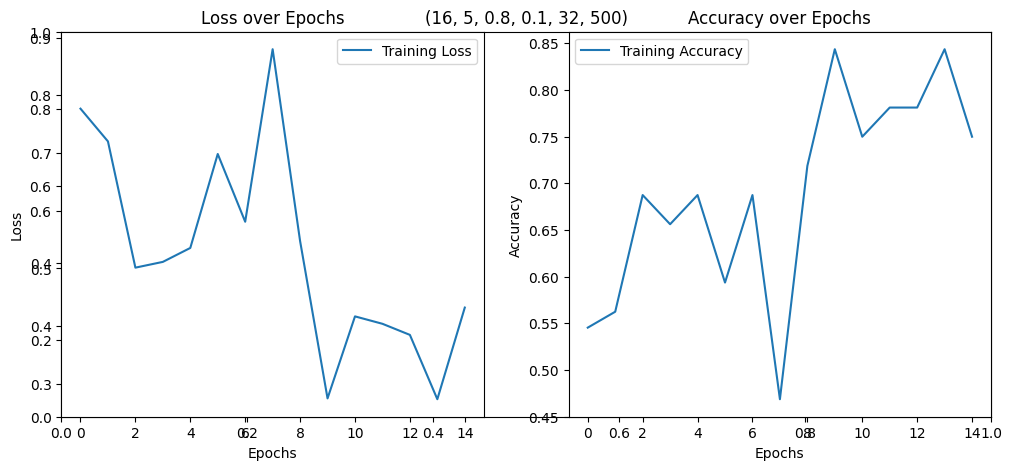

In [15]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset[0].x.shape[1]
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = 2
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs


hyperparams_list = [
    # (16, 4, 0.5, 0.005, 32, 700),
    # (16, 4, 0.5, 0.01, 32, 500),
    (16, 5, 0.8, 0.1, 32, 500),
    # (16, 7, 0.2, 0.001, 32, 500),
    # (16, 7, 0.6, 0.01, 32, 300),
    # (16, 7, 0.8, 0.001, 32, 700),
    # (32, 4, 0.2, 0.01, 32, 300),
]

for hyperparams in hyperparams_list:
    # hyperparams = (16, 7, 0.5, 0.05, 32, 500)
    # hyperparams = (dim, layers, margin, lr, batch_size, num_pairs)
    newargs = NewArgs(*hyperparams)
    model = GraphMatchingNetwork(newargs)
    optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
    pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
    acc = train(
        model,
        optimizer,
        pairs,
        labels,
        newargs.batch_size,
        str(hyperparams),
    )

In [52]:
split_dataset = {
    "class0": [],
    "class1": [],
}

for graph in dataset:
    if graph.y.item() == 0:
        split_dataset["class0"].append(graph)
    elif graph.y.item() == 1:
        split_dataset["class1"].append(graph)

tensor([1]) tensor([1])


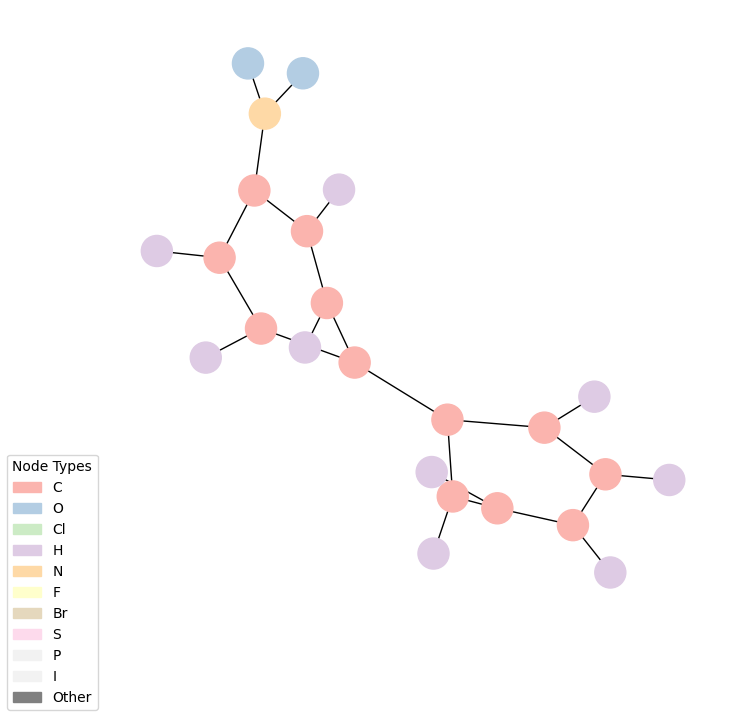

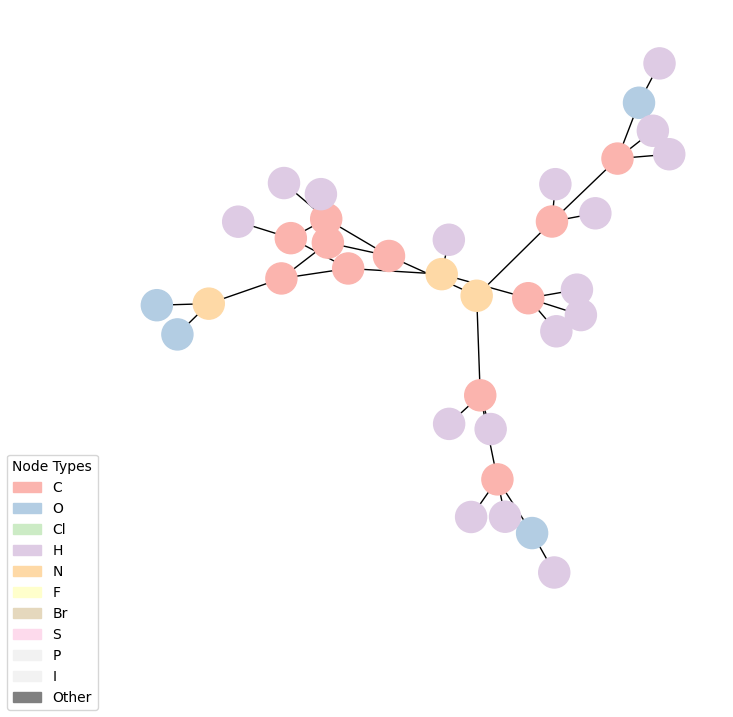

In [58]:
summaries = []
graph_pairs = []
c = "class1"
idx1 = random.sample(range(len(split_dataset[c])), 1)[0]
idx2 = random.sample(range(len(split_dataset[c])), 1)[0]
graph1, graph2 = split_dataset[c][idx1], split_dataset[c][idx2]
model.eval()
print(graph1.y, graph2.y)
plot_mutag(graph1)
plot_mutag(graph2)
feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
    feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)

embeddings, attentions = extract_embeddings_and_attention(
    model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)

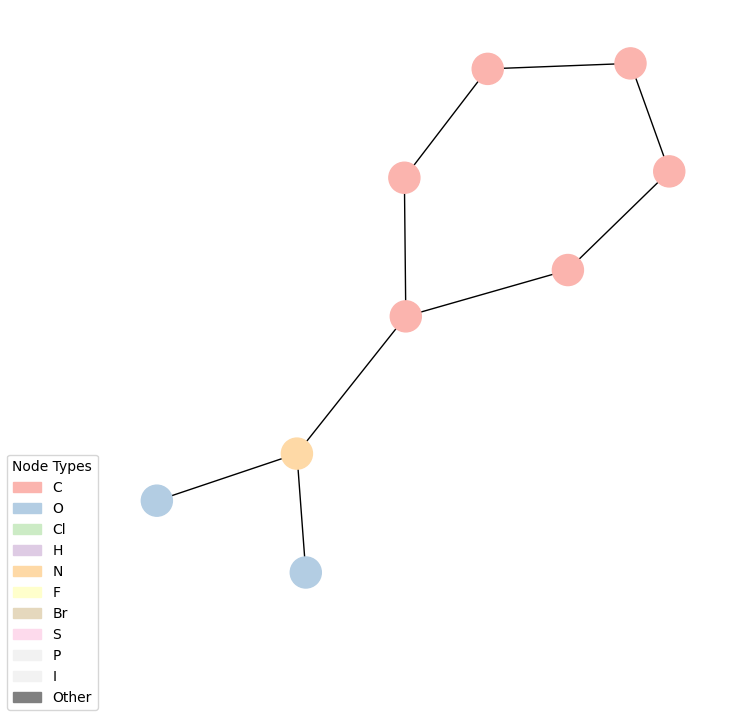

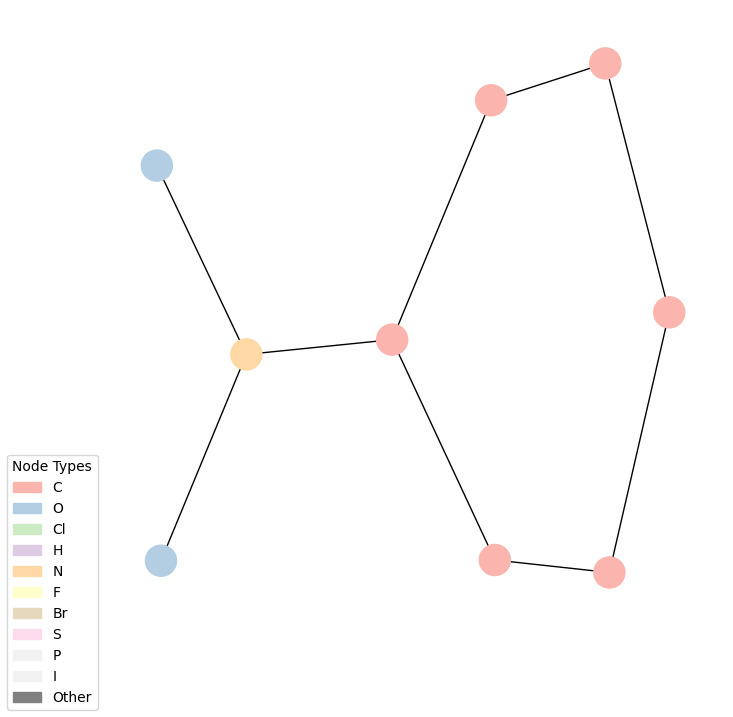

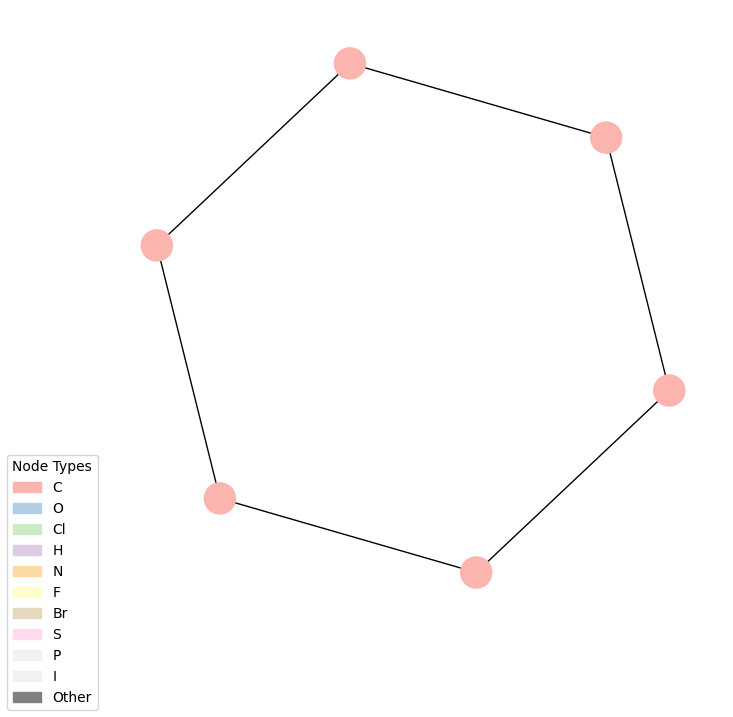

In [60]:
most_nodes = 0
largest_summary = 0
t_of_largest = 0
layer_of_largest = 0
ts = []

graph_pairs.append((graph1, graph2))

br = False
pattern_lens = []
most_nodes = 0
largest_summary = None
t_of_largest = 0
layer_of_largest = 0
ts = []
for i in range(5):
    for t in [0.05]:
        attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=t)
        mp = mutual_pairs(attention_nodes, i)
        vf2 = MCS(mp)
        patterns = vf2.find_mcs(graph1, graph2)
        # print(len(patterns))
        if patterns != []:
            pattern = patterns[0]

            # if len(pattern) > largest_summary:
            #     largest_summary = len(pattern)
            # else:
            #     break

            # print(len(pattern))

            g1_subgraph, g2_subgraph = create_subgraphs(pattern, graph1, graph2)

            if (
                nx.is_isomorphic(
                    to_networkx(g1_subgraph, to_undirected=True),
                    to_networkx(g2_subgraph, to_undirected=True),
                )
                and len(pattern) > 2
            ):
                summary = Data(
                    x=(g1_subgraph.x),
                    edge_index=g1_subgraph.edge_index,
                )

                if len(pattern) > most_nodes:
                    most_nodes = len(pattern)
                    largest_summary = summary
                    t_of_largest = t
                    layer_of_largest = i + 1

                plot_mutag(summary)

summaries.append(largest_summary)